In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
%matplotlib inline  
#plt.rcParams['figure.figsize'] = [15, 10]
plt.style.use('seaborn')

In [15]:
import numpy as np
from datetime import datetime
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model
import seaborn as sns

# Autoencoder zur Anomalie Erkennung

In [16]:
data_path = r"C:\\Users\\Armin\\Documents\\Code\\Studienarbeit\\crypto_daten_kaggle\\"
crypto_df = pd.read_hdf('train.h5')
btc = crypto_df[crypto_df["Asset_ID"]==1]
btc['timestamp'] = pd.to_datetime(btc['timestamp'], unit='s')
#btc = btc.set_index("timestamp")

C:\Users\Armin\AppData\Local\Temp/ipykernel_21108/268182317.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc['timestamp'] = pd.to_datetime(btc['timestamp'], unit='s')


In [17]:
print(btc)

            index           timestamp  Asset_ID   Count          Open  \
1942619         2 2018-01-01 00:01:00         1   229.0  13835.194000   
1942620        10 2018-01-01 00:02:00         1   235.0  13835.036000   
1942621        18 2018-01-01 00:03:00         1   528.0  13823.900000   
1942622        26 2018-01-01 00:04:00         1   435.0  13802.512000   
1942623        34 2018-01-01 00:05:00         1   742.0  13766.000000   
...           ...                 ...       ...     ...           ...   
3898896  24236739 2021-09-20 23:56:00         1  1940.0  42983.780000   
3898897  24236753 2021-09-20 23:57:00         1  2026.0  42904.197143   
3898898  24236767 2021-09-20 23:58:00         1  1986.0  42859.385714   
3898899  24236781 2021-09-20 23:59:00         1  4047.0  42839.012802   
3898900  24236795 2021-09-21 00:00:00         1  2698.0  43009.961250   

                 High       Low         Close      Volume          VWAP  \
1942619  14013.800000  13666.11  13850.176000   

Start date is:  2018-01-01 00:01:00
End date is:  2021-09-21 00:00:00
524149


C:\Users\Armin\AppData\Local\Temp/ipykernel_21108/74217688.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Close'] = scaler.transform(train[['Close']])
C:\Users\Armin\AppData\Local\Temp/ipykernel_21108/74217688.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Close'] = scaler.transform(test[['Close']])


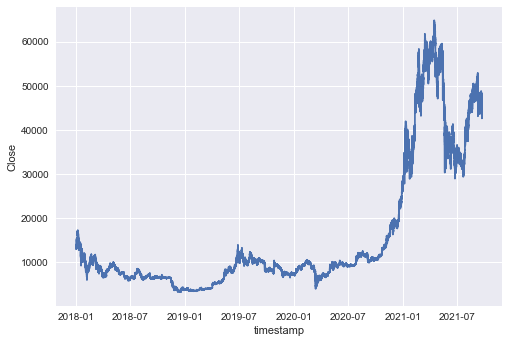

In [18]:
df = btc[['timestamp', 'Close']]

sns.lineplot(x=df['timestamp'], y=df['Close'])

print("Start date is: ", df['timestamp'].min())
print("End date is: ", df['timestamp'].max())

#Change train data from Mid 2017 to 2019.... seems to be a jump early 2017
train, test = df.loc[df['timestamp'] <= datetime.strptime('31/12/18 00:00:00','%d/%m/%y %H:%M:%S' )], df.loc[df['timestamp'] > datetime.strptime('31/12/18 00:00:00','%d/%m/%y %H:%M:%S')]


print(len(train))

#Convert pandas dataframe to numpy array
#dataset = dataframe.values
#dataset = dataset.astype('float32') #COnvert values to float

#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
#scaler = MinMaxScaler() #Also try QuantileTransformer
scaler = StandardScaler()
scaler = scaler.fit(train[['Close']])

train['Close'] = scaler.transform(train[['Close']])
test['Close'] = scaler.transform(test[['Close']])


#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 2. We will make timesteps = 3. 
#With this, the resultant n_samples is 5 (as the input data has 9 rows).

seq_size = 30  # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.


def to_sequences(x, y, seq_size=1):
    x_values = []
    y_values = []

    for i in range(len(x)-seq_size):
        #print(i)
        x_values.append(x.iloc[i:(i+seq_size)].values)
        y_values.append(y.iloc[i+seq_size])
        
    return np.array(x_values), np.array(y_values)

trainX, trainY = to_sequences(train[['Close']], train['Close'], seq_size)
testX, testY = to_sequences(test[['Close']], test['Close'], seq_size)


In [19]:
print(len(testX))

1432103


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128)               66560     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 repeat_vector_1 (RepeatVect  (None, 30, 128)          0         
 or)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_3 (Dropout)         (None, 30, 128)           0         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 1)            129       
 tributed)                                            

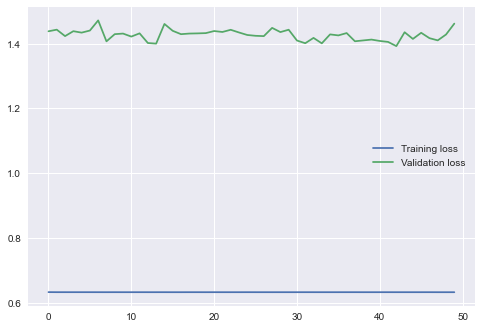

In [20]:
model = Sequential()
model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(rate=0.2))

model.add(RepeatVector(trainX.shape[1]))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(trainX.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

# fit model
history = model.fit(trainX, trainY, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

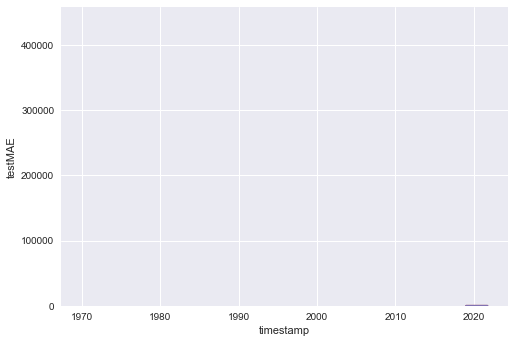

In [21]:
trainPredict = model.predict(trainX)
trainMAE = np.mean(np.abs(trainPredict - trainX), axis=1)
plt.hist(trainMAE, bins=30)
max_trainMAE = 0.3  #or Define 90% value of max as threshold.

testPredict = model.predict(testX)
testMAE = np.mean(np.abs(testPredict - testX), axis=1)
plt.hist(testMAE, bins=30)

#Capture all details in a DataFrame for easy plotting
anomaly_df = pd.DataFrame(test[seq_size:])
anomaly_df['testMAE'] = testMAE
anomaly_df['max_trainMAE'] = max_trainMAE
anomaly_df['anomaly'] = anomaly_df['testMAE'] > anomaly_df['max_trainMAE']
anomaly_df['Close'] = test[seq_size:]['Close']

#Plot testMAE vs max_trainMAE
sns.lineplot(x=anomaly_df['timestamp'], y=anomaly_df['testMAE'])
sns.lineplot(x=anomaly_df['timestamp'], y=anomaly_df['max_trainMAE'])

anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]


In [25]:
print(anomalies.timestamp)

2466798   2018-12-31 00:31:00
2466799   2018-12-31 00:32:00
2466800   2018-12-31 00:33:00
2466801   2018-12-31 00:34:00
2466802   2018-12-31 00:35:00
                  ...        
3898896   2021-09-20 23:56:00
3898897   2021-09-20 23:57:00
3898898   2021-09-20 23:58:00
3898899   2021-09-20 23:59:00
3898900   2021-09-21 00:00:00
Name: timestamp, Length: 1249597, dtype: datetime64[ns]


In [ ]:
model.save_weights("./autoencoder/model_lstm_autoencoder_01")

<AxesSubplot:xlabel='timestamp', ylabel='Close'>

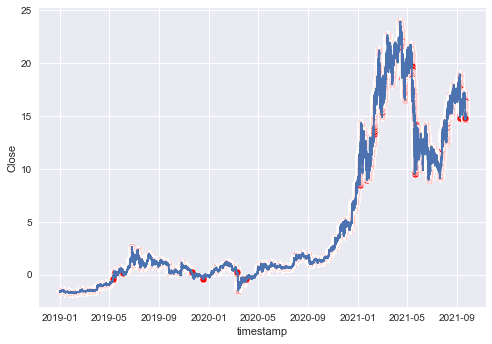

In [22]:
sns.lineplot(x=anomaly_df['timestamp'], y=anomaly_df['Close'])
sns.scatterplot(x=anomalies['timestamp'], y=anomalies['Close'], color='r')
